# P6 - Catégorisez automatiquement des questions

## Librairies et méthodes d'importation

In [1]:
# Librairies classiques
import pandas as pd
import numpy as np
import datetime
from time import time

# Librairies de traitement de texte
import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

from p6_functions import *
CT_DIR_SAVE = '../autotag/save/'

## Récupération des données

In [2]:
df_train = pd.read_csv(CT_DIR_SAVE + 'df_train.csv')
df_test = pd.read_csv(CT_DIR_SAVE + 'df_test.csv')
print(df_train.shape)
print(df_test.shape)
df_train.head()

(152855, 2)
(38214, 2)


,TextCleaned,TagsCleaned
0,appli opac form use decim doubl valu want use ...,c# winforms type-conversion decimal opacity
1,percentag width child element absolut posit pa...,html css css3 internet-explorer-7
2,calcul someon age c# given datetim repres pers...,c# .net datetime
3,calcul rel time c# given specif datetim valu d...,c# datetime time datediff relative-time-span
4,determin user timezon standard way web server ...,javascript html browser timezone timezoneoffset


In [3]:

# Samples pour les tests
if True:
    df_train = df_train[:100000]
    df_test = df_test[:10000]
    print(df_train.shape)
    print(df_test.shape)

(100000, 2)
(10000, 2)


## Choix d'un nombre de tags

In [4]:
max_features_tags = 400

# Liste de tous les tags
top_tags = load_obj(CT_DIR_SAVE + 'top_tags')

# Liste des tags
max_tags = []
for i in range(0, max_features_tags):
    max_tags.append(top_tags[i][0])

# Méthode pour enlever les tags hors de la liste officielle de classification
def cleanTags(p_val):
    ret = []
    for word in str(p_val).split():
        if word in max_tags:
            ret.append(word)
    return " ".join(ret)

../autotag/save/top_tags loaded


In [5]:
print(top_tags[:10])

[['c#', 26446], ['.net', 16452], ['java', 13844], ['asp.net', 12347], ['javascript', 9584], ['c++', 9410], ['php', 8607], ['python', 6953], ['sql', 6542], ['sql-server', 5972]]


## Nettoyage

In [6]:
df_train['Tags'] = df_train['TagsCleaned']
df_test['Tags'] = df_test['TagsCleaned']

In [7]:
# On enlève tous les tags qui ne font pas parti du top choisi
df_train['TagsCleaned'] = df_train['TagsCleaned'].apply(cleanTags)
df_test['TagsCleaned'] = df_test['TagsCleaned'].apply(cleanTags)

In [8]:
# On enlève de l'entrainement les données qui se retrouvent sans target
df_train = df_train[df_train['TagsCleaned'].str.len()>0]
print(df_train.shape)

(95081, 3)


In [9]:
df_train.head()

,TextCleaned,TagsCleaned,Tags
0,appli opac form use decim doubl valu want use ...,c# winforms,c# winforms type-conversion decimal opacity
1,percentag width child element absolut posit pa...,html css internet-explorer-7,html css css3 internet-explorer-7
2,calcul someon age c# given datetim repres pers...,c# .net datetime,c# .net datetime
3,calcul rel time c# given specif datetim valu d...,c# datetime time,c# datetime time datediff relative-time-span
4,determin user timezon standard way web server ...,javascript html browser,javascript html browser timezone timezoneoffset


In [10]:
df_test.head()

,TextCleaned,TagsCleaned,Tags
0,javascript access deni object support properti...,jquery,jquery ajaxcontroltoolkit thickbox
1,suspend weblog datasourc command line wonder a...,database oracle jdbc,database oracle jdbc weblogic
2,creat gener object base type variabl need crea...,c# .net generics,c# .net generics
3,test iphon app limit network access way simul ...,iphone testing networking,iphone testing networking
4,wpf multipl valu properti would like appli sty...,wpf properties,wpf properties


## Méthode de scoring personnelle

In [11]:
# Méthode de scoring comparant les tags trouvés aux tags réels, et fonction du nombre de tags réels
# Note entre 0 et 1
# Plus on est proche de 1 mieux c'est
def final_score(clf, X, y_test_mlb, n_tags=5):
    
    decfun = []
    if hasattr(clf, 'decision_function'):
        decfun = clf.decision_function(X)
    elif hasattr(clf, 'predict_proba'):
        decfun = clf.predict_proba(X)
    else:
        return 0

    note = []
    # Nombre de tags réels total
    nb_tot = y_test_mlb.sum()
    # Boucle sur chaque résultat
    for i in range(len(y_test_mlb)):
        # Si le résultat réel a au moins un tag
        nb_res = y_test_mlb[i].sum()
        if (nb_res > 0):
            # Indice des tags réels
            res = np.argsort(i)[ :-(nb_res+1): -1]
            # Indice des 5 meilleurs tags prédits
            res_pred = np.argsort(decfun[i])[ :-(n_tags+1): -1]
            # Rapport entre les deux
            note.append(len(np.intersect1d(res, res_pred)))
    #print('note =',note)
    print('Ma note =',np.round(np.sum(note)/nb_tot, 3))


## Mode supervisé - Analyse de Title+Body vs Tags

In [12]:
#X_train, X_test, y_train, y_test = train_test_split(dataraw['TextCleaned'], dataraw['TagsCleaned'], test_size=0.3)
X_train = df_train['TextCleaned']
X_test = df_test['TextCleaned']
y_train = df_train['TagsCleaned']
y_test = df_test['TagsCleaned']

In [13]:
# On binarise la target
mlb = preprocessing.MultiLabelBinarizer(classes=max_tags)
mlb.fit([w.split() for w in y_train])

y_train_mlb = mlb.transform([w.split() for w in y_train])
y_test_mlb = mlb.transform([w.split() for w in y_test])

In [14]:
def test_model(mod):
    t0 = time()

    pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    #('vect', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(mod))])

    parameters = {
        #'vect__min_df': (5, 10, 15),
        'vect__min_df': [5],
        #'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_df': [0.5],
        #'vect__max_features': (None, 5000, 10000),
        'vect__max_features': [None],
        #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
        'vect__ngram_range': [(1, 2)],  # unigrams or bigrams
        #'tfidf__use_idf': (True, False),
        'tfidf__use_idf': [True],
        #'tfidf__norm': ['l1', 'l2'],
        'tfidf__norm': ['l2'],
    }
    gs = GridSearchCV(pipeline, parameters, cv=5)
    gs.fit(X_train, y_train_mlb)

    print("Best score: %0.3f" % gs.best_score_)
    print("Best parameters set:")
    best_parameters = gs.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

    print ("Accuracy Score: ", accuracy_score(y_test_mlb, gs.best_estimator_.predict(X_test)))

    result = get_best_tags(gs.best_estimator_, X_test, mlb)
    #print(result[:5])
    final_score(gs.best_estimator_, X_test, y_test_mlb)
    print("done in %0.3fs." % (time() - t0))
    

### LinearSVC - bon score, bonnes perf

In [15]:
test_model(LinearSVC())

Best score: 0.191
Best parameters set:
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__max_features: None
	vect__min_df: 5
	vect__ngram_range: (1, 2)
Accuracy Score:  0.2221
Ma note = 0.175
done in 2268.369s.


### RandomForestClassifier - score moyen, temps moyen

In [16]:
#test_model(RandomForestClassifier())

Best score: 0.046

Best parameters set:

	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__max_features: None
	vect__min_df: 5
	vect__ngram_range: (1, 2)
Accuracy Score:  0.075

../autotag/save/Classifier.pkl saved
../autotag/save/MultiLabelBinarizer.pkl saved
[['javascript' 'asp.net' '.net' 'css' 'database']
 ['java' 'linq' 'batch-file' 'vim' 'design-patterns']
 ['c#' 'interface' 'generics' 'user-interface' 'version-control']
 ['iphone' 'linux' 'database' 'c#' 'controls']
 ['wpf' 'perl' 'css' 'graphics' 'file-io']]
 
done in 363.318s.

### SGDClassifier - score moyen, bonne perf

In [17]:
from sklearn.linear_model import SGDClassifier
test_model(SGDClassifier(loss="log", max_iter=5, tol=None))

Best score: 0.033
Best parameters set:
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__max_features: None
	vect__min_df: 5
	vect__ngram_range: (1, 2)
Accuracy Score:  0.0784
Ma note = 0.467
done in 1073.539s.


### AdaBoostClassifier - bon score, temps médiocre

In [18]:
#from sklearn.ensemble import AdaBoostClassifier
#test_model(AdaBoostClassifier())

Best score: 0.137

Best parameters set:

	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__max_features: None
	vect__min_df: 5
	vect__ngram_range: (1, 2)
Accuracy Score:  0.146

../autotag/save/Classifier.pkl saved
../autotag/save/MultiLabelBinarizer.pkl saved
[['javascript' 'jquery' 'ajax' 'asp.net' 'dynamic']
 ['dynamic' 'flex3' 'uitableview' 'sharepoint-2007' 'silverlight-2.0']
 ['c#' 'fluent-nhibernate' 'flex3' 'dynamic' 'uitableview']
 ['networking' 'flex3' 'uitableview' 'dynamic' 'silverlight-2.0']
 ['colors' 'wpf' 'sharepoint-2007' 'silverlight-2.0' 'uitableview']]
 
done in 6639.907s.

### ExtraTreesClassifier - score faible, temps moyen

In [19]:
#from sklearn.ensemble import ExtraTreesClassifier
#test_model(ExtraTreesClassifier())

Best score: 0.045

Best parameters set:

	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__max_features: None
	vect__min_df: 5
	vect__ngram_range: (1, 2)
Accuracy Score:  0.075

../autotag/save/Classifier.pkl saved
../autotag/save/MultiLabelBinarizer.pkl saved
[['asp.net' 'debugging' 'javascript' 'css' 'wpf']
 ['java' 'c#' 'java-ee' 'windows-vista' 'crystal-reports']
 ['c#' '.net' 'nhibernate' 'powershell' 'linq']
 ['iphone' 'sqlite' 'sockets' 'bash' 'ios']
 ['wpf' 'c#' 'internationalization' 'wcf' 'localization']]
 
done in 330.661s.

### GradientBoostingClassifier - score moyen, temps énorme

In [20]:
#from sklearn.ensemble import GradientBoostingClassifier
#test_model(GradientBoostingClassifier())

Best score: 0.102

Best parameters set:

	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__max_features: None
	vect__min_df: 5
	vect__ngram_range: (1, 2)
Accuracy Score:  0.1

../autotag/save/Classifier.pkl saved
../autotag/save/MultiLabelBinarizer.pkl saved
[['javascript' 'flex3' 'dynamic' 'uitableview' 'silverlight-2.0']
 ['flex3' 'dynamic' 'uitableview' 'silverlight-2.0' 'fluent-nhibernate']
 ['interface' 'uitableview' 'flex3' 'sharepoint-2007' 'dynamic']
 ['ios' 'sharepoint-2007' 'dynamic' 'uitableview' 'silverlight-2.0']
 ['colors' 'wpf' 'uitableview' 'sharepoint-2007' 'silverlight-2.0']]

done in 62652.606s.

### GaussianProcessClassifier

In [21]:
# Ne prend pas de matrice sparse
#from sklearn.gaussian_process import GaussianProcessClassifier
#test_model(GaussianProcessClassifier())

## Vectorisation

In [22]:
# Vectorizer
t0 = time()
max_df=.8
min_df=5
#max_features=10000
max_features=1000

print('X_train.shape', X_train.shape)
print('y_train_mlb.shape', y_train_mlb.shape)

vect = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, stop_words='english')
X_train_tf = vect.fit_transform(X_train)
print('X_train_tf.shape', X_train_tf.shape)
X_test_tf = vect.transform(X_test)
print('X_test_tf.shape', X_test_tf.shape)

tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=X_train_tf.shape[1])
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
print('X_train_tfidf.shape', X_train_tfidf.shape)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print('X_test_tfidf.shape', X_test_tfidf.shape)

print("Vectorizer done in %0.3fs." % (time() - t0))


X_train.shape (95081,)
y_train_mlb.shape (95081, 400)
X_train_tf.shape (95081, 1000)
X_test_tf.shape (10000, 1000)
X_train_tfidf.shape (95081, 1000)
X_test_tfidf.shape (10000, 1000)
Vectorizer done in 15.944s.


## Réduction dimensionnelle

### PCA

PCA done in 47.767s.
Nombre de dimensions original : 1000
Nombre de dimensions pour 90 % d'explication : 506
506  dimensions pour 90 % de variance


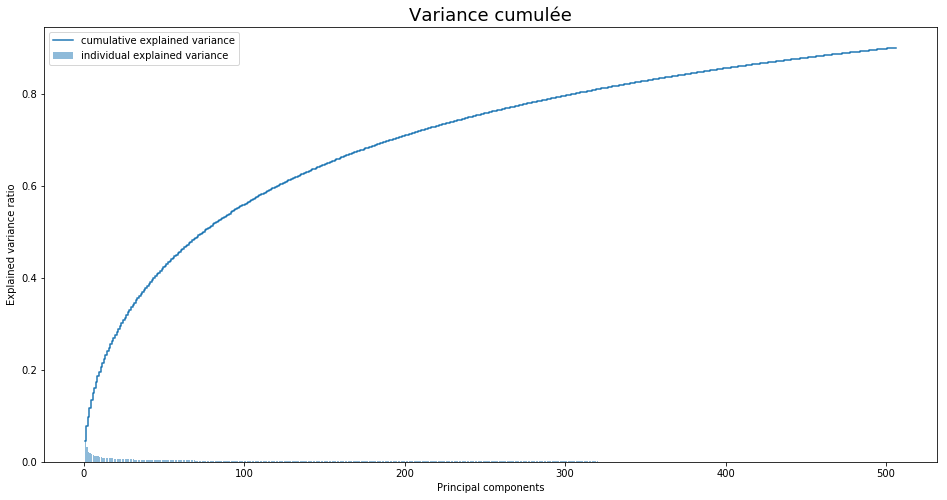

In [23]:
testPCA(X_train_tf.toarray());

PCA done in 38.329s.
Nombre de dimensions original : 1000
Nombre de dimensions pour 90 % d'explication : 721
721  dimensions pour 90 % de variance


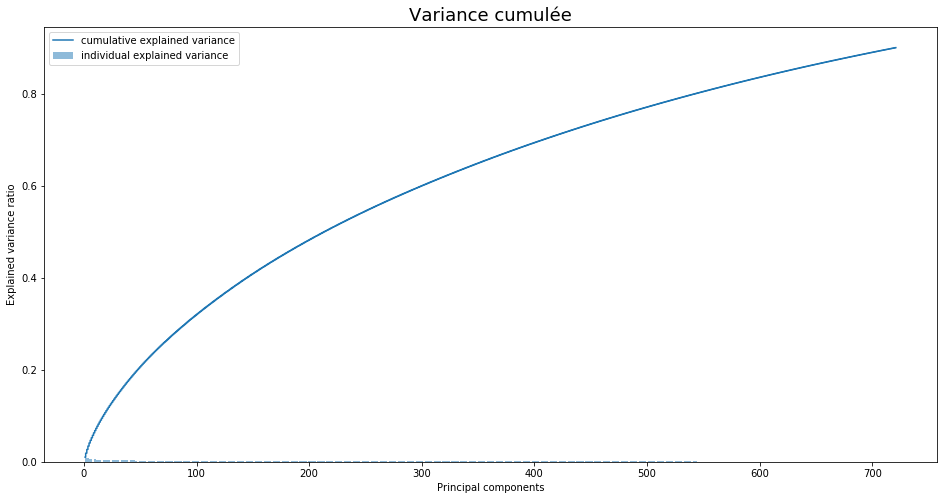

In [24]:
testPCA(X_train_tfidf.toarray());

### TruncatedSVD

TSVD done in 99.539s.
Nombre de dimensions original : 1000
506  dimensions pour 90 % de variance


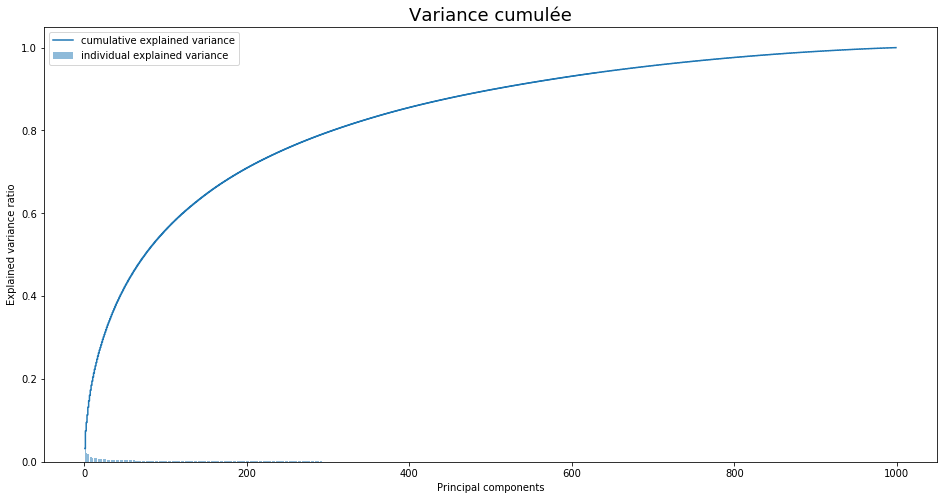

In [25]:
best_reduc, X_train_tf_red, best_n_components = testTSVD_sparse(X_train_tf)

TSVD done in 122.635s.
Nombre de dimensions original : 1000
721  dimensions pour 90 % de variance


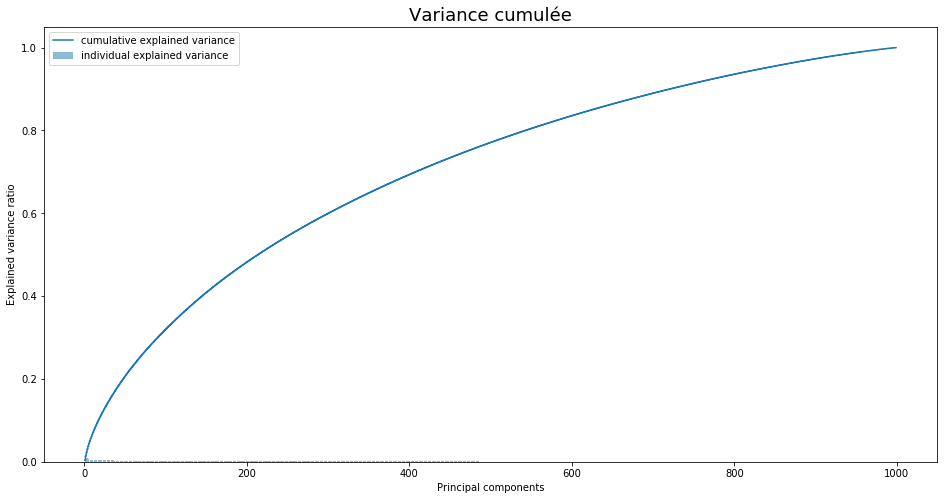

In [26]:
testTSVD_sparse(X_train_tfidf);

### LinearDiscriminantAnalysis

LDA done in 188.169s.
Nombre de dimensions original : 1000
734  dimensions pour 90 % de variance


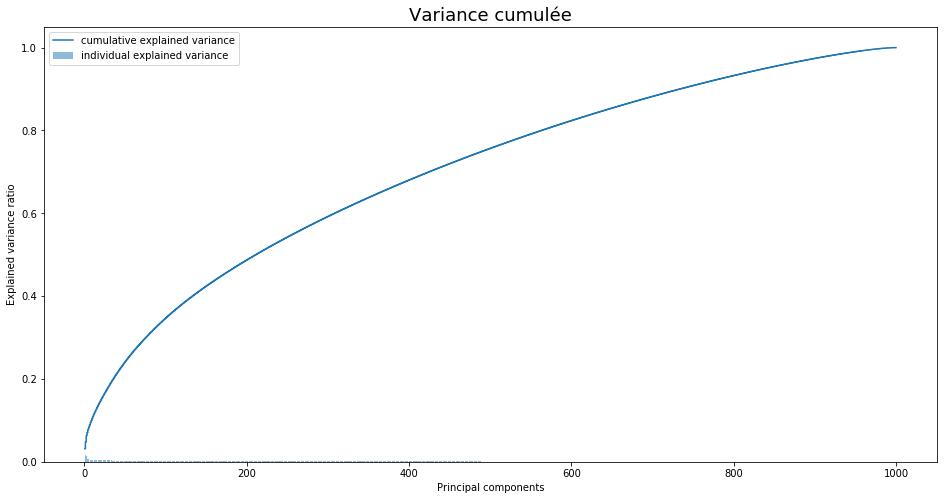

In [27]:
testLDA(X_train_tf.toarray(), y_train);

LDA done in 176.186s.
Nombre de dimensions original : 1000
779  dimensions pour 90 % de variance


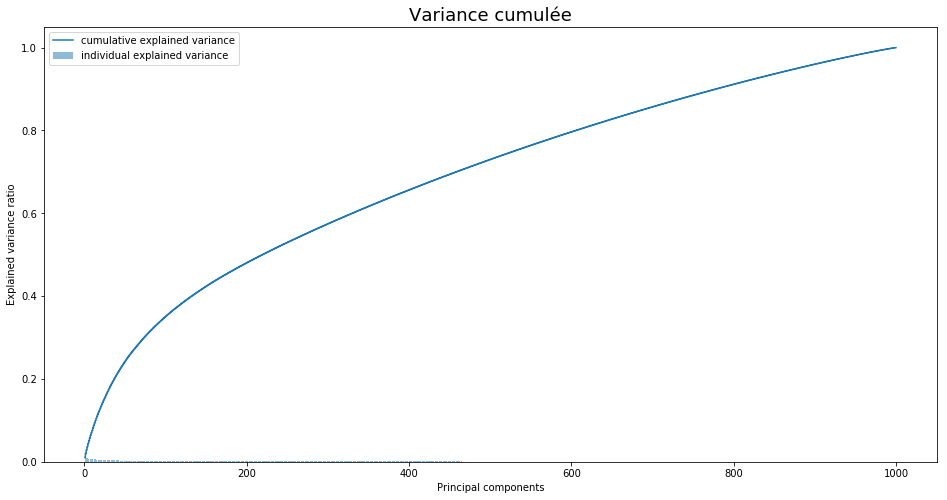

In [28]:
testLDA(X_train_tfidf.toarray(), y_train);

## Exploration LinearSVC

In [29]:
t0 = time()

pipeline = Pipeline([
('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
#('vect', TfidfVectorizer()),
('clf', OneVsRestClassifier(LinearSVC()))])

parameters = {
    #'vect__min_df': (5, 10, 15),
    'vect__min_df': [5],
    #'vect__max_df': (0.4, 0.5, 0.6, 0.75, 1.0),
    'vect__max_df': [0.5],
    #'vect__max_features': (None, 5000, 10000),
    'vect__max_features': [None],
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'vect__ngram_range': [(1, 1)],  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    'tfidf__use_idf': [True],
    #'tfidf__norm': ['l1', 'l2'],
    'tfidf__norm': ['l2'],
}
gs = GridSearchCV(pipeline, parameters, cv=5)
gs.fit(X_train, y_train_mlb)

print("Best score: %0.3f" % gs.best_score_)
print("Best parameters set:")
best_parameters = gs.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

print ("Accuracy Score: ", accuracy_score(y_test_mlb, gs.best_estimator_.predict(X_test)))

result = get_best_tags(gs.best_estimator_, X_test, mlb, b_save=True, b_Dir=CT_DIR_SAVE)
print(result[:5])

final_score(gs.best_estimator_, X_test, y_test_mlb)
print("done in %0.3fs." % (time() - t0))


Best score: 0.185
Best parameters set:
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__max_features: None
	vect__min_df: 5
Accuracy Score:  0.2134
../autotag/save/Classifier.pkl saved
../autotag/save/MultiLabelBinarizer.pkl saved
[['javascript' 'ajax' 'jquery' 'asp.net' 'asp.net-ajax']
 ['asp.net' 'batch-file' 'java' 'sql' 'jdbc']
 ['c#' 'generics' '.net-2.0' 'c++' 'vb.net']
 ['iphone' 'cocoa-touch' 'networking' 'testing' 'tdd']
 ['wpf' 'xaml' 'controls' '.net' 'binding']]
Ma note = 0.18
done in 845.219s.


In [30]:
gs.best_estimator_

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...lti_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1))])

In [31]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, max_features=None)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC()))])
parameters = {
#    "clf__estimator__penalty": ['l1','l2'],
#    "clf__estimator__loss": ['hinge','squared_hinge'],
    "clf__estimator__loss": ['squared_hinge'],
#    "clf__estimator__dual": [True,False],
#    "clf__estimator__tol": [.000001,.00001,.0001],
    "clf__estimator__tol": [.000001,.0000001],
#    "clf__estimator__C": [0.1,1,10,100],    
#    "clf__estimator__max_iter": [10, 100, 200, 1000],    
}

model_tunning = GridSearchCV(pipeline, parameters, cv=3, scoring='accuracy')
model_tunning.fit(tfidf_train, y_train_mlb)

print ("Accuracy Score: ", accuracy_score(y_test_mlb, model_tunning.best_estimator_.predict(tfidf_test)))
final_score(model_tunning.best_estimator_, tfidf_test, y_test_mlb)
print("done in %0.3fs." % (time() - t0))
model_tunning.best_estimator_


Accuracy Score:  0.2134
Ma note = 0.18
done in 1664.720s.


Pipeline(memory=None,
     steps=[('clf', OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=1e-06,
     verbose=0),
          n_jobs=1))])

### Utilisation de la réduction dimensionnelle

In [32]:
t0 = time()

# Jeu de test
X_test_tf_red = best_reduc.transform(X_test_tf)

mod = LinearSVC(penalty='l2', loss='squared_hinge', tol=.000001, C=1, max_iter=200)
ovr = OneVsRestClassifier(mod)
gs = GridSearchCV(ovr, {}, cv=3)
gs.fit(X_train_tf_red, y_train_mlb)

print("Best score: %0.3f" % gs.best_score_)
print ("Accuracy Score: ", accuracy_score(y_test_mlb, gs.best_estimator_.predict(X_test_tf_red)))

result = get_best_tags(gs.best_estimator_, X_test_tf_red, mlb, b_save=True, b_Dir=CT_DIR_SAVE+'bestLinearSVC')
print(result[:5])
final_score(gs.best_estimator_, X_test_tf_red, y_test_mlb)
print("done in %0.3fs." % (time() - t0))


Best score: 0.084
Accuracy Score:  0.1175
../autotag/save/bestLinearSVCClassifier.pkl saved
../autotag/save/bestLinearSVCMultiLabelBinarizer.pkl saved
[['javascript' 'ajax' 'jquery' 'internet-explorer-6' 'asp.net-ajax']
 ['maven-2' 'ruby' 'command-line' 'c#' 'unix']
 ['generics' 'c#' 'types' 'c' 'database']
 ['iphone' 'cocoa-touch' 'networking' 'objective-c' 'windows']
 ['wpf' 'listbox' 'xaml' 'colors' 'controls']]
Ma note = 0.183
done in 15197.826s.
